In [2]:
from ipywidgets import interact
import numpy as np
import pandas as pd

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import Legend, LegendItem


from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS

from sklearn.neighbors import KNeighborsRegressor

from joblib import dump, load

from warnings import simplefilter
simplefilter("ignore", FutureWarning)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

## Import Data

In [3]:
data_1 = pd.read_csv('transactions_1.csv')
data_2 = pd.read_csv('transactions_2.csv')

# concat two csv file to one dataframe
data_all = pd.concat([data_1, data_2]).drop(columns=['Unnamed: 0']).reset_index()
data_all = data_all.drop(columns=['index'])

# parsing datetime feature with pd.Timestamp()
data_all['date'] = [pd.Timestamp(i) for i in data_all.date]

data_all

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31 09:31:08.873000+00:00
1,6689489,XZ6UVEYK40,2017-02-03 16:59:16.610000+00:00
2,6689489,XZ6UVEYK40,2017-02-05 19:47:55.353000+00:00
3,6689489,XZ6UVEYK40,2017-02-05 19:48:14.633000+00:00
4,6689489,XZ6UVEYK40,2017-02-06 09:59:49.053000+00:00
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17 10:06:43.037000+00:00
975951,2552305,5RPSDK28JR,2017-10-27 17:49:54.483000+00:00
975952,6004163,I2IYFZIO6X,2019-01-09 16:31:08.133000+00:00
975953,6632569,0A4G5LZWCP,2017-03-29 16:25:05.907000+00:00


## Exctract data of each customer 

In [4]:
def prepare_data(data, customer_id, start='2017-01', end='2019-04'):
    """
    function for easy exctraction of our model input from original dataset
    Parameters
    ----------
    data: pandas DataFrame
        main dataset with customer_id, product_id and Timestamp
    
    customer_id: int
        
    start: string
        start year and month in '2020-01' format
        
    end: string
        end year and month in '2020-01' format *** this month will not be included ***

    Returns
    -------
    y_series: pandas.Series
        sales data as a pd.Series and pd.period_range index
    """
    data = data.copy(deep=True)
    data = data[data.customer_id == customer_id]
    p_index = pd.period_range(start=start, end=end, periods=None, freq='M', name='Priod')
    freq = []
    for i in range(len(p_index)-1):
        start_month = str(p_index[i]).split('-')[1]
        end_month = str(p_index[i+1]).split('-')[1]
        start_year = str(p_index[i]).split('-')[0]
        end_year = str(p_index[i+1]).split('-')[0]
        freq.append(len(data[data.date >= pd.Timestamp(f'{start_year}-{start_month}-01T00:00:00Z')][data.date <= pd.Timestamp(f'{end_year}-{end_month}-01T00:00:00Z')]))
        
    y_series = pd.Series(freq, index=p_index[:-1], name='Sales',dtype='float64')
    return  y_series

prepare_data(data_all, 6689489)

Priod
2017-01     917.0
2017-02    1071.0
2017-03    1789.0
2017-04    1386.0
2017-05     910.0
2017-06    1979.0
2017-07    1306.0
2017-08    1465.0
2017-09     480.0
2017-10    1011.0
2017-11     762.0
2017-12     513.0
2018-01    1018.0
2018-02    1005.0
2018-03     948.0
2018-04     563.0
2018-05     685.0
2018-06    1172.0
2018-07    1379.0
2018-08    1637.0
2018-09     846.0
2018-10    1088.0
2018-11     658.0
2018-12     882.0
2019-01     974.0
2019-02     628.0
2019-03     907.0
Freq: M, Name: Sales, dtype: float64

## Build and Save Model

sMAPE Loss : 0.2451239145841276


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sales'>)

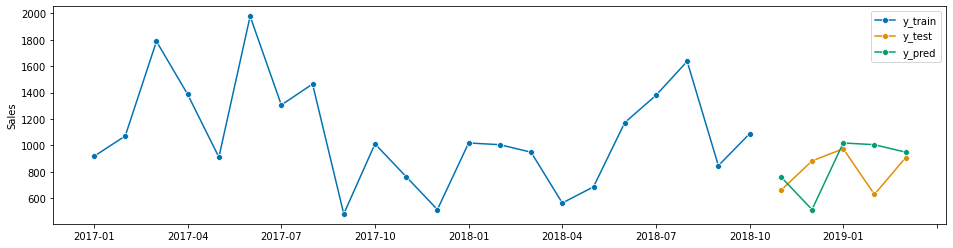

In [5]:
def forecast(data, customer_id, start='2017-01', end='2019-04', model_type='NaiveForecaster', test_size_month=5, model_storage_path='Models'):   
    """
    Main function for build forcasting model on selected customer and time interval, save the model and plotting 
    
    Parameters
    ----------
    data: pandas DataFrame
        main dataset with customer_id, product_id and Timestamp
    
    customer_id: int
        
    start: string
        start year and month in '2020-01' format
        
    end: string
        end year and month in '2020-01' format *** this month will not be included ***

    model_type:
        type of model to use in forecasting
        select from : ['NaiveForecaster', 'PolynomialTrendForecaster', 'ThetaForecaster', 'KNeighborsRegressor',
                       'ExponentialSmoothing', 'AutoETS', 'AutoARIMA', 'TBATS', 'BATS', 'EnsembleForecaster']
        
    test_size_month:
        number of month that will be excluded from end of interval to use as test dataset

    model_storage_path: string
        the folder that you want to store saved models
        
    Returns
    -------
    sMAPE Loss: print
    
    plot: matplotlib figure
        plot train, test and predicted values
    """
    y_train, y_test = temporal_train_test_split(prepare_data(data, customer_id, start=start, end=end), test_size=test_size_month)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    if model_type == 'NaiveForecaster':
        forecaster = NaiveForecaster(strategy="last", sp=12)
    elif model_type == 'PolynomialTrendForecaster':
        forecaster = PolynomialTrendForecaster(degree=2)
    elif model_type == 'ThetaForecaster':
        forecaster = ThetaForecaster(sp=6)
    elif model_type == 'KNeighborsRegressor':
        regressor = KNeighborsRegressor(n_neighbors=1)
        forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
    elif model_type == 'ExponentialSmoothing':
        forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
    elif model_type == 'AutoETS':
        forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
    elif model_type == 'AutoARIMA':
        forecaster = AutoARIMA(sp=12, suppress_warnings=True)
    elif model_type == 'TBATS':
        forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
    elif model_type == 'BATS':
        forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)    
    elif model_type == 'EnsembleForecaster':
        forecaster = EnsembleForecaster([
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        ("holt",ExponentialSmoothing(trend="add", damped_trend=False, seasonal="multiplicative", sp=12),),
        ("damped",ExponentialSmoothing(trend="add", damped_trend=True, seasonal="multiplicative", sp=12),),])

    try:
        forecaster.fit(y_train)
    except:
        forecaster.fit(y_train+1)
        
    y_pred = forecaster.predict(fh)
    dump(forecaster, f'{model_storage_path}/{customer_id}_{model_type}_{start}_{end}_{test_size_month}.model')

    print('sMAPE Loss :', smape_loss(y_pred, y_test))
    plot = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return plot
    
forecast(data_all, 6689489, start='2017-01', end='2019-04', model_type='NaiveForecaster', test_size_month=5)

sMAPE Loss : 0.2451239145841276


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sales'>)

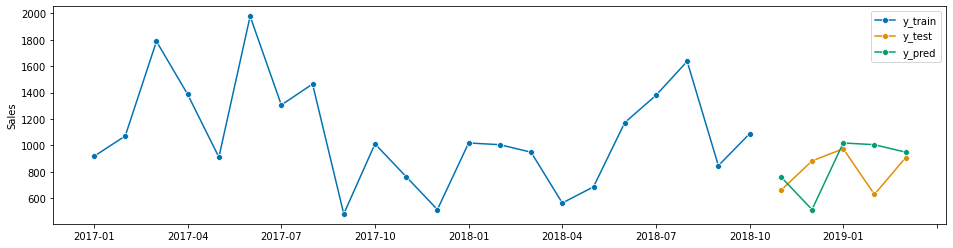

In [6]:
def load_forecast(data,  model_path='Models/6689489_NaiveForecaster_2017-01_2019-04_5.model'):   
    """
    Load saved forcasting model and plotting 
    
    Parameters
    ----------
    data: pandas DataFrame
        main dataset with customer_id, product_id and Timestamp
    
    model_path: .model file
        path to previously saved model

    Returns
    -------
    sMAPE Loss: print
    
    plot: matplotlib figure
        plot train, test and predicted values
    """
    y_train, y_test = temporal_train_test_split(prepare_data(data, int(model_path.split('_')[0].split('/')[-1]),
                                                start=model_path.split('_')[-3],
                                                end=model_path.split('_')[-2]),
                                                test_size=int(model_path.split('_')[-1].split('.')[0]))
    fh = ForecastingHorizon(y_test.index, is_relative=False)

    f = load(model_path)

    y_pred = f.predict(fh)

    print('sMAPE Loss :', smape_loss(y_pred, y_test))
    plot = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return plot


load_forecast(data_all, model_path='Models/6689489_NaiveForecaster_2017-01_2019-04_5.model')